In [9]:
library(tidyverse)

source("../../utils/plots_eda.R")

Loading required package: viridisLite



# Fed Correction ...

... after FC app ...

In [2]:
path_to_fed <- "/home/yuliya/repos/cosybio/FedComBat/datasets/Ecoli_proteomics/after/fed_res/"
zip_files <- list.files(path = path_to_fed, pattern = "\\.zip$", full.names = TRUE)

for(i in seq_along(zip_files)) {
  zipfile <- zip_files[i]
  zip_contents <- unzip(zipfile, list = TRUE)$Name
  csv_files <- zip_contents[grepl("\\.csv$", zip_contents, ignore.case = TRUE)]
  
  # If no CSV file is found, skip this zip
  if(length(csv_files) == 0) {
    warning(sprintf("No CSV file found in zip: %s", zipfile))
    next
  }
  csv_to_extract <- csv_files[1]
  new_csv_name <- file.path(path_to_fed, sprintf("%d_bayes_data.csv", i))
  unzip(zipfile, files = csv_to_extract, exdir = path_to_fed)
  
  # Determine the path to the extracted file (handles potential subdirectories)
  extracted_csv_path <- file.path(path_to_fed, csv_to_extract)
  
  # If the extracted file is inside a subdirectory, move it to the main folder
  if (!file.exists(extracted_csv_path)) {
    # Sometimes the unzip creates subfolders. List files recursively.
    extracted_files <- list.files(path_to_fed, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
    # Find the matching file (by comparing filenames ignoring directory structure)
    candidate <- extracted_files[basename(extracted_files) == basename(csv_to_extract)]
    if(length(candidate) > 0) {
      extracted_csv_path <- candidate[1]
    } else {
      warning(sprintf("Extracted CSV file not found for zip: %s", zipfile))
      next
    }
  }
  
  # Rename (or move) the extracted CSV file to the new filename
  if(!file.rename(from = extracted_csv_path, to = new_csv_name)) {
    warning(sprintf("Failed to rename file: %s", extracted_csv_path))
  }
}


In [9]:
fed_expression <- NULL

for(i in 1:5){
    expr_data <- read.table(paste0(path_to_fed, i, "_bayes_data.csv"), header = TRUE, sep = "\t") %>% column_to_rownames("sample_id") %>% t() %>% as.data.frame() %>%
        rownames_to_column("gene_id") 
    print(paste0("Samples: ", ncol(expr_data), "; Features: ", nrow(expr_data)))
    # save data
    if(is.null(fed_expression)){
        fed_expression <- expr_data
    } else {        
        fed_expression <- full_join(fed_expression, expr_data, by = "gene_id")
    }
    print(paste0("Combined Samples: ", ncol(fed_expression), "; Features: ", nrow(fed_expression)))
    print(" ")
}


[1] "Samples: 21; Features: 2067"
[1] "Combined Samples: 21; Features: 2067"
[1] " "
[1] "Samples: 20; Features: 2067"
[1] "Combined Samples: 40; Features: 2067"
[1] " "
[1] "Samples: 20; Features: 2067"
[1] "Combined Samples: 59; Features: 2067"
[1] " "
[1] "Samples: 21; Features: 2067"
[1] "Combined Samples: 79; Features: 2067"
[1] " "
[1] "Samples: 21; Features: 2067"
[1] "Combined Samples: 99; Features: 2067"
[1] " "


In [10]:
# write to file
write.table(fed_expression, file = "after/fed_combined_data.csv", sep = "\t", 
            row.names = FALSE, col.names = TRUE, quote = FALSE)

# Load data

In [10]:
all_metadata <- read.table("before/all_design.tsv", header = TRUE, sep = "\t")
# all_metadata$Status <- all_metadata$lum
all_metadata$Dataset <- as.character(all_metadata$batch)

In [12]:
corrected_expr <- read.table(
    "after/all_corrected_R_expr.tsv", 
    header = TRUE, sep = "\t")

corrected_expr <- corrected_expr %>% column_to_rownames("gene_id") 
print(paste0("Samples: ", ncol(corrected_expr), "; Features: ", nrow(corrected_expr)))
corrected_expr <- corrected_expr[, all_metadata$sample_id]


[1] "Samples: 98; Features: 2067"


In [13]:
fed_expression <- read.table(
    "after/fed_combined_data.csv", 
    header = TRUE, sep = "\t")

fed_expression <- fed_expression %>% column_to_rownames("gene_id") 
print(paste0("Samples: ", ncol(fed_expression), "; Features: ", nrow(fed_expression)))
fed_expression <- fed_expression[rownames(corrected_expr), all_metadata$sample_id]


[1] "Samples: 98; Features: 2067"


In [15]:
# plot the combined data
print("Plotting combined data")
plot_res <- plot_diagnostic(fed_expression, all_metadata, "FedCombat corrected",
                            log_transform = TRUE, with_rowname = TRUE)
layout <- (plot_res[[1]] + plot_res[[2]] ) / 
          (plot_res[[3]] )
ggsave("after/diagnostic_plot_correcter_Fed.png", 
            plot = layout, width = 12, height = 12)

[1] "Plotting combined data"
[1] "..plotting.."


No id variables; using all as measure variables



# Min Max and mean absolute error

In [16]:
# Calculate value-to-value mean, max, and mean absolute difference
mean_diff <- mean(as.matrix(abs(corrected_expr - fed_expression), na.rm = TRUE))
max_diff <- max(abs(corrected_expr - fed_expression), na.rm = TRUE)
min_diff <- min(abs(corrected_expr - fed_expression), na.rm = TRUE)

print(paste0("Min difference: ", min_diff))
print(paste0("Mean difference: ", mean_diff))
print(paste0("Max difference: ", max_diff))


[1] "Min difference: 0"
[1] "Mean difference: 7.18070280910526e-15"
[1] "Max difference: 1.03028696685215e-13"


In [32]:
diff_vec <- c( abs( as.matrix(corrected_expr) - as.matrix(fed_expression) ) )
var_diff <- var(diff_vec, na.rm = TRUE)
if (is.na(var_diff)) var_diff <- 0
print(var_diff)
format(var_diff, digits = 3, scientific = TRUE)  # → "6.67e-28"


[1] 6.665573e-28


[1] "6.67e-28"

NULL

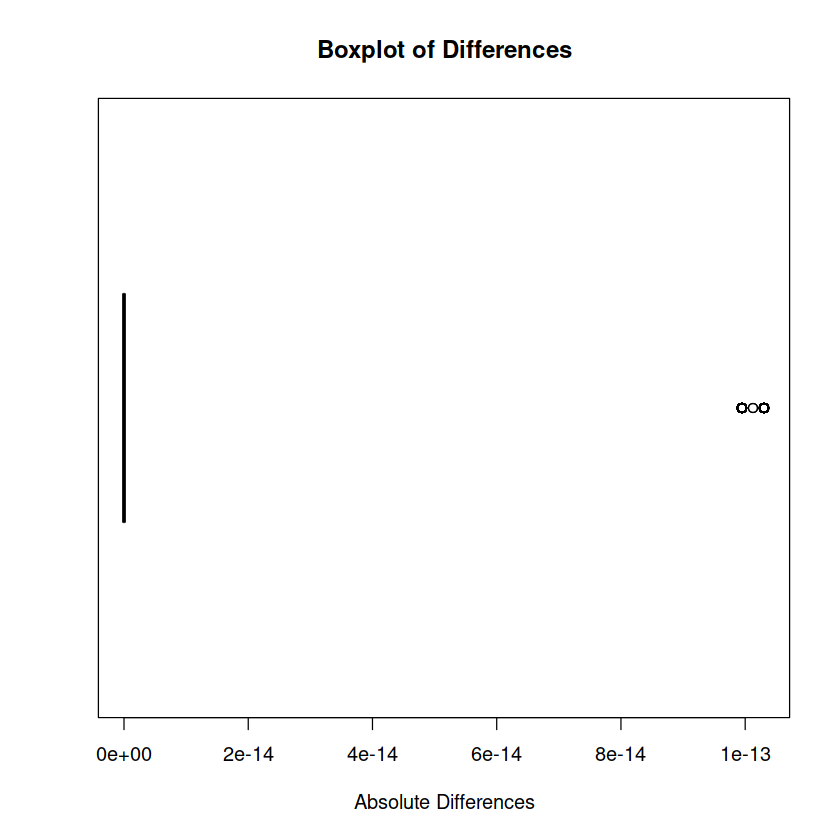

In [ ]:
boxplot(abs(as.numeric(unlist(corrected_expr)) - as.numeric(unlist(fed_expression))),
        main = "Boxplot of Differences", xlab = "Absolute Differences",
        # add values to the plot - for the mean and the median
        horizontal = TRUE) +
    theme_minimal()


NULL

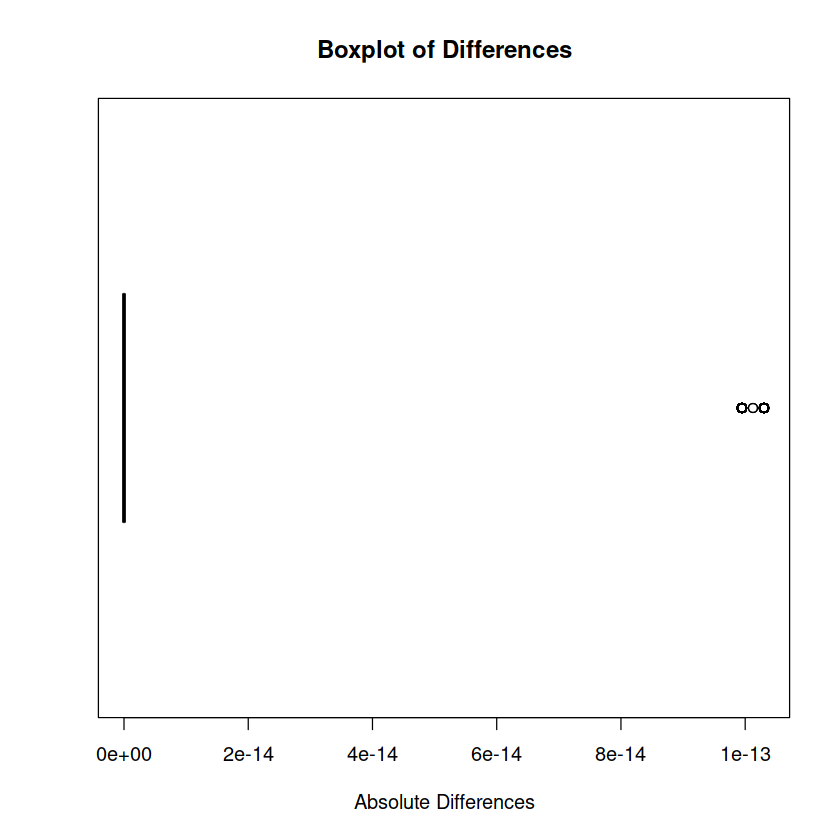

In [17]:
boxplot(abs(as.numeric(unlist(corrected_expr)) - as.numeric(unlist(fed_expression))),
        main = "Boxplot of Differences", xlab = "Absolute Differences",
        # add values to the plot - for the mean and the median
        horizontal = TRUE) +
    theme_minimal()
